<a href="https://colab.research.google.com/github/hrishi483/OCR/blob/main/Torch_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Dataset: IAM_Words


In [1]:
!wget -q https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [ ]:
!mv /content/data /content/drive/MyDrive/Pipeline/custom_ocr_model_pyTorch

In [1]:
import os
import numpy as np

np.random.seed(42)

In [2]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


# Step0: Preparing Data

In [3]:
base_path = "data"
# base_path = "/content/drive/MyDrive/Pipeline/data"
words_list=[]
words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
  if line[0]=="#":
    continue
  if line.split(" ")[1]!="err":
    words_list.append(line)

print(len(words_list))
np.random.shuffle(words_list)

split_idx = int(0.9*len(words_list))

train_samples=words_list[:split_idx]
test_samples=words_list[split_idx:]

val_split_idx=int(0.5*len(test_samples))
val_samples = test_samples[:val_split_idx]
test_samples= test_samples[val_split_idx:]

print(len(train_samples), len(val_samples), len(test_samples))


96456
86810 4823 4823


In [4]:
train_samples[100]

'g04-017-07-04 ok 170 1034 2210 8 8 . .\n'

In [5]:
base_path = "data"
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(val_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [6]:
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some train label samples.
print(train_labels_cleaned[:10])

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

Maximum length:  21
Vocab size:  78
['sure', 'he', 'during', 'of', 'booty', 'gastronomy', 'boy', 'The', 'and', 'in']


**Note: ** Later we are using 0 padding this might affect the output.
Therefore padding with -1

In [7]:
from torchtext.vocab import build_vocab_from_iterator
#build vocabulary
train_labels_cleaned = [x.upper() for x in train_labels_cleaned]
vocab = build_vocab_from_iterator(map(list, train_labels_cleaned))

# Create a mapping from characters to integers
# char_to_idx = {char: idx for idx, char in enumerate(vocab)}
char_to_num = vocab.get_stoi()

# Create a mapping from integers back to characters
num_to_char = {i:char for char,i in char_to_num.items()}
print("Character to Num:", char_to_num)
print("Num to Character:", num_to_char)

Character to Num: {'*': 51, '/': 49, '&': 47, '#': 46, '4': 45, '6': 44, '3': 38, ')': 43, '9': 37, ';': 36, '?': 35, '2': 34, '!': 33, '+': 50, '0': 30, 'P': 17, 'L': 9, 'R': 7, '5': 40, 'M': 13, 'S': 6, '.': 20, ':': 39, '1': 29, 'D': 10, ',': 21, 'N': 5, 'O': 3, '(': 41, 'C': 11, 'Z': 32, 'A': 2, "'": 24, 'I': 4, 'H': 8, 'T': 1, 'Q': 31, 'W': 15, 'Y': 18, 'V': 22, 'F': 14, 'G': 16, '8': 42, 'B': 19, 'E': 0, 'K': 23, '-': 25, 'J': 28, '"': 26, '7': 48, 'U': 12, 'X': 27}
Num to Character: {51: '*', 49: '/', 47: '&', 46: '#', 45: '4', 44: '6', 38: '3', 43: ')', 37: '9', 36: ';', 35: '?', 34: '2', 33: '!', 50: '+', 30: '0', 17: 'P', 9: 'L', 7: 'R', 40: '5', 13: 'M', 6: 'S', 20: '.', 39: ':', 29: '1', 10: 'D', 21: ',', 5: 'N', 3: 'O', 41: '(', 11: 'C', 32: 'Z', 2: 'A', 24: "'", 4: 'I', 8: 'H', 1: 'T', 31: 'Q', 15: 'W', 18: 'Y', 22: 'V', 14: 'F', 16: 'G', 42: '8', 19: 'B', 0: 'E', 23: 'K', 25: '-', 28: 'J', 26: '"', 48: '7', 12: 'U', 27: 'X'}


### Resizing Images without Distortion

In [8]:
import torch
from torchvision import transforms
def distortion_free_resize(image,img_size):
  w,h=img_size
  resizer = transforms.Resize(size=(h,w))
  image = resizer(image)

  pad_height = h-image.size()[0]
  pad_width  = w-image.size()[1]

  if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
  else:
      pad_height_top = pad_height_bottom = pad_height // 2

  if pad_width % 2 != 0:
      width = pad_width // 2
      pad_width_left = width + 1
      pad_width_right = width
  else:
      pad_width_left = pad_width_right = pad_width // 2

  #Add Padding on both sides
  padder = transforms.Pad(padding=(pad_width_left,pad_height_top,pad_width_right,pad_height_bottom),fill=0)
  image  = padder(image)

  image = image.permute((1, 2, 0)).numpy()
  # image=torch.fliplr(image)
  return image


In [77]:
#HyperParametres
batch_size = 64
learning_rate=3e-4
padding_token = 99
image_width = 128
image_height = 32
num_epochs = 1
max_len=max_len
oov=len(list(char_to_num.values()))+1


from PIL import Image
import matplotlib.pyplot as plt
from torch.nn import ZeroPad1d
from torchvision import transforms

def preprocess_image(image_path,img_size=(image_width,image_height)):
  image=Image.open(image_path)
  tensor_transform=transforms.ToTensor()
  image=tensor_transform(image)
  image=distortion_free_resize(image,img_size)
  # image = image.type('torch.FloatTensor')/ 255.0
  return image

def vectorize_label(label):
    char_labels=[*label]
    label = torch.Tensor(np.array([char_to_num.get(char,oov) for char in char_labels]))
    length = label.shape[0]
    pad_amount = max_len - length
    #Padding with -1 since 0 is already in the num_to_chars array
    padding_tensor = torch.full((pad_amount,), fill_value=-1)
    label = torch.cat((label, padding_tensor))
    # print("label length = ",len(label),"Pad Amount = ",pad_amount,"Length = ",len(label),"Char Label = ",len(char_labels))
    return label.numpy()

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

class DataSet:
  def __init__(self,images,labels,transform=None):
    self.images = images
    self.labels = labels
    self.transform=transforms

  def __len__(self):
    return len(self.labels)

  def __getitem__(self,idx):
    img = self.images[idx]

    img = preprocess_image(img)
    return img,self.labels[idx]

from torch.nn.utils.rnn import pad_sequence

# def collate_fn(batch):
#     images, labels = zip(*batch)

#     # Pad sequences to the universal max_len
#     labels_padded = pad_sequence(labels, batch_first=True, padding_value=oov)

    # return images, torch.stack(labels_padded)

def prepare_dataset(image_paths, labels):
    vectorized_labels = [vectorize_label(label) for label in labels]
    return DataSet(image_paths,vectorized_labels)


In [22]:
label="SURE"
char_labels=[*label]
label = torch.Tensor(np.array([char_to_num.get(char,oov) for char in char_labels]))
length = label.shape[0]
pad_amount = max_len - length
print(char_labels)

padding_tensor = torch.full((pad_amount,), fill_value=-1)
label = torch.cat((label, padding_tensor))
print(label)
print("label length = ",len(label),"Pad Amount = ",pad_amount,"Length = ",len(label),"Char Label = ",len(char_labels))

['S', 'U', 'R', 'E']
tensor([ 6., 12.,  7.,  0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1.])
label length =  21 Pad Amount =  17 Length =  21 Char Label =  4


In [23]:
from torch.utils.data import DataLoader
train_ds     = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds= prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds      = prepare_dataset(test_img_paths, test_labels_cleaned)

train_loader = DataLoader(train_ds,batch_size=batch_size,shuffle=True)
val_loader   = DataLoader(validation_ds,batch_size=batch_size,shuffle=True)
test_loader  =DataLoader(test_ds,batch_size=batch_size,shuffle=False)

In [ ]:
next(iter(train_loader))

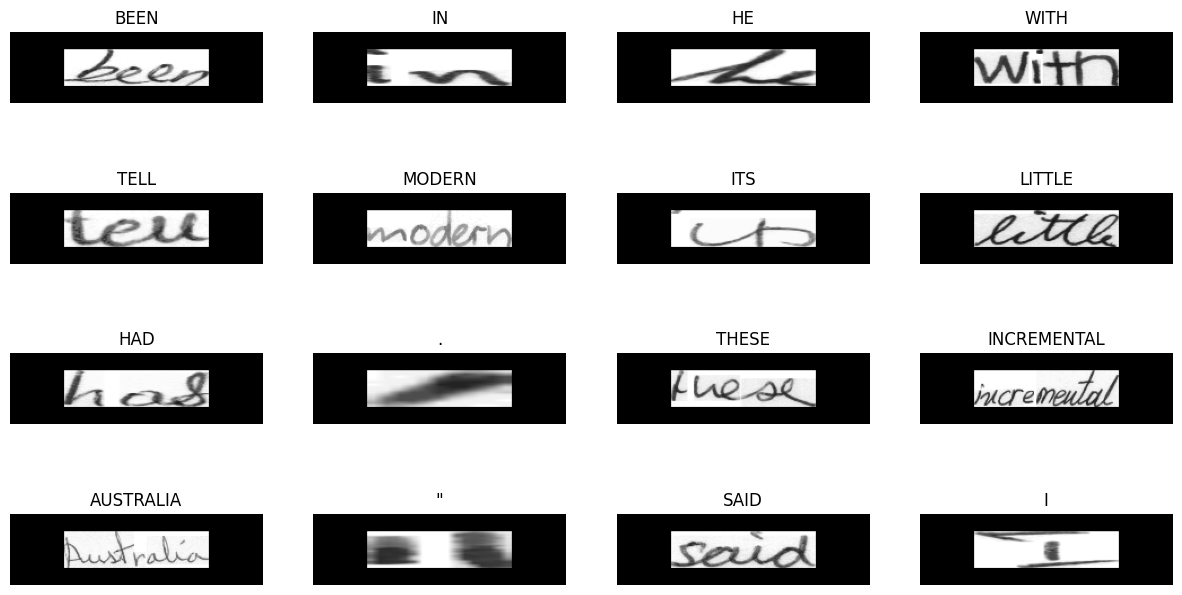

In [24]:
num_to_char[-1]="-1"
for images,labels in train_loader:
  _, ax = plt.subplots(4, 4, figsize=(15, 8))

  for i in range(16):
      # img   = Image.open(images[i])
      img  = images[i]

      label = labels[i].numpy()
      # Convert to string.
      char_labels = [num_to_char.get(num,oov) for num in label]
      label = ''.join(char_labels).replace("-1","")
      ax[i // 4, i % 4].imshow(img, cmap="gray")
      ax[i // 4, i % 4].set_title(label)
      ax[i // 4, i % 4].axis("off")

  break
plt.show()

# MODEL

In [72]:
bs = batch_size
import torch.nn as nn
import torch.nn.functional as F
class OCRmodel(nn.Module):
  def __init__(self,num_chars):
    super(OCRmodel,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=(3,3),padding="same")
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

    self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),padding="same")
    self.pool2 = nn.MaxPool2d(kernel_size=(2,2))

    #RNN Layer
    self.linear1=nn.Linear(960,64)
    self.dropout=nn.Dropout(0.2)
    # Bidirectional LSTM layers
    self.lstm1 = nn.LSTM(256, 128, bidirectional=True, batch_first=True,num_layers=2, dropout=0.25)    #Multiply by

    #Dense Layer
    self.output = nn.Linear(128*2,num_chars+1)

    #CTC Layer

  def forward(self,images,targets=None):
      bs,c,h,w = images.size()
      print(bs,c,h,w)
      #First Convolution Layer
      x = F.relu(self.conv1(images))
      print(x.size())
      x = self.pool1(x)
      print(x.size())

      #Second Convolution Layer
      x = F.relu(self.conv2(x))
      print(x.size())
      x = self.pool2(x)
      print(x.size()) #bs,out_channels,h,w

      #Linear Layer
      #Permute so as to make time axis in RNN as the width of image
      x = torch.permute(x,(0,3,1,2)) #bs,w,out_channels,h
      print(x.size())
      x = x.reshape(bs,x.size(1),-1)
      print(x.size())
      x= F.relu(self.linear1(x))
      print(x.size())
      #LSTM Layers
      x,_ = self.lstm1(x)

      print(x.size())
      # Dense: Can applying softmax here!
      # x = F.softmax(self.output(x))
      x = self.output(x)
      print(x.size())
      return x,None




In [73]:
print("Char to Num:",len(char_to_num.keys())+1)
model = OCRmodel(len(char_to_num.keys())+1)
outputs = model(img_tensor,labels)


Char to Num: 53
1 1 63 224
torch.Size([1, 32, 63, 224])
torch.Size([1, 32, 31, 112])
torch.Size([1, 64, 31, 112])
torch.Size([1, 64, 15, 56])
torch.Size([1, 56, 64, 15])
torch.Size([1, 56, 960])
torch.Size([1, 56, 64])
torch.Size([1, 56, 256])
torch.Size([1, 56, 54])


In [75]:
print(model.parameters)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.8,patience=0.8,verbose=True)


tensor([19.,  7.,  3., 15.,  5., 24.,  6., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1.])
torch.Size([63, 224, 1])
torch.Size([1, 63, 224, 1])
torch.Size([1, 1, 63, 224])


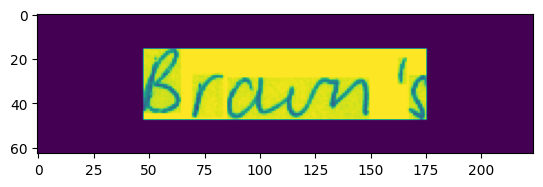

In [39]:
for images,label in train_loader:
  img= images[0]
  labels=label[0]
  break
print(labels)


plt.imshow(img)
print(img.size())
img_tensor = img.unsqueeze(0)
print(img_tensor.size())
img_tensor = torch.permute(img_tensor,(0,3,1,2))
print(img_tensor.size())


In [ ]:
for epoch in range(num_epochs):
  for images,labels in train_loader:
    model.train()
    outputs = model(images)
    #Decode the outputs before passing to the loss functiuon

